In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
# matplotlib.use("TkAgg")
%matplotlib tk
import matplotlib.pyplot as plt

## 2D dataset

In [3]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))


In [4]:
# %matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
from convex_lib import ConvexNN

In [6]:
EPOCHS = 1000
actf = nn.LeakyReLU
# actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

# Convex NN

In [7]:
cvxNet = ConvexNN([2, 10, 10, 1], actf)
optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [8]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Epoch: 0, Loss:0.16876716911792755
Epoch: 100, Loss:0.030533315613865852
Epoch: 200, Loss:0.022505339235067368
Epoch: 300, Loss:0.017119117081165314
Epoch: 400, Loss:0.016996392980217934
Epoch: 500, Loss:0.016984665766358376
Epoch: 600, Loss:0.016978269442915916
Epoch: 700, Loss:0.016972793266177177
Epoch: 800, Loss:0.01697075366973877
Epoch: 900, Loss:0.016961494460701942
Epoch: 999, Loss:0.01695745624601841


/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


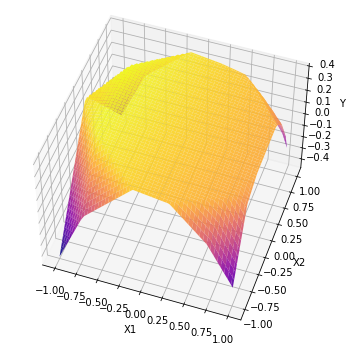

In [9]:
%matplotlib inline

y_ = yout.data.cpu().numpy().reshape(Y.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(49, -71)
ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(0.1)
plt.show()

## Plotting Contour Plot

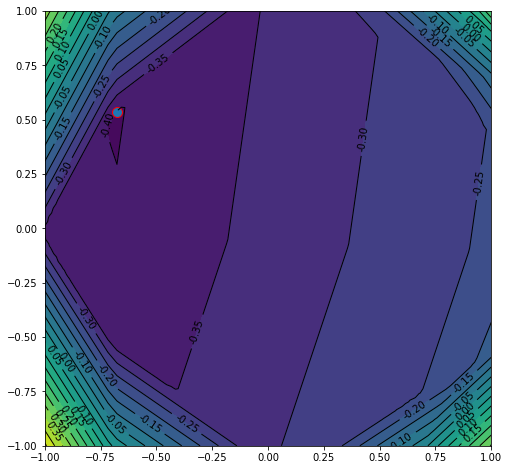

In [10]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")

In [11]:
min_val = y_.min()
min_val

-0.40305847

In [12]:
minima = xx[None, y_.argmin()]
minima

tensor([[-0.6768,  0.5354]])

In [13]:
# minima[0, 0] = minima[0, 0] + 0.25
# minima[0, 1] = minima[0, 1] - 0.1

## Finding Mimima by using gradient descent

In [14]:
xmin = torch.randn_like(minima)
xmin = torch.autograd.Variable(xmin, requires_grad=True)
xmin

tensor([[ 2.7603, -1.6296]], requires_grad=True)

In [15]:
optim = torch.optim.Adam([xmin], lr=0.001)
STEPS = 4000

### Training Loop

In [21]:
for step in range(STEPS):
    optimizer.zero_grad() 

    ymin = cvxNet(xmin)
    xgrad = torch.autograd.grad(outputs=ymin, inputs=xmin, grad_outputs=torch.ones_like(ymin), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xmin.grad = xgrad
    
    optim.step()
    
    if step%100 == 0:
        print(f"STEPS: {step}, xmin: {xmin.data}, min_value: {ymin.data}")

STEPS: 0, xmin: tensor([[-0.6784,  0.5323]]), min_value: tensor([[-0.4031]])
STEPS: 100, xmin: tensor([[-0.6754,  0.5337]]), min_value: tensor([[-0.4029]])
STEPS: 200, xmin: tensor([[-0.6775,  0.5362]]), min_value: tensor([[-0.4031]])
STEPS: 300, xmin: tensor([[-0.6779,  0.5349]]), min_value: tensor([[-0.4031]])
STEPS: 400, xmin: tensor([[-0.6788,  0.5337]]), min_value: tensor([[-0.4030]])
STEPS: 500, xmin: tensor([[-0.6779,  0.5328]]), min_value: tensor([[-0.4031]])
STEPS: 600, xmin: tensor([[-0.6780,  0.5328]]), min_value: tensor([[-0.4031]])
STEPS: 700, xmin: tensor([[-0.6767,  0.5354]]), min_value: tensor([[-0.4031]])
STEPS: 800, xmin: tensor([[-0.6777,  0.5355]]), min_value: tensor([[-0.4031]])
STEPS: 900, xmin: tensor([[-0.6774,  0.5342]]), min_value: tensor([[-0.4031]])
STEPS: 1000, xmin: tensor([[-0.6793,  0.5331]]), min_value: tensor([[-0.4030]])
STEPS: 1100, xmin: tensor([[-0.6786,  0.5326]]), min_value: tensor([[-0.4030]])
STEPS: 1200, xmin: tensor([[-0.6769,  0.5336]]), min

In [22]:
xgrad

tensor([[-0.9709,  0.6971]], grad_fn=<AddBackward0>)

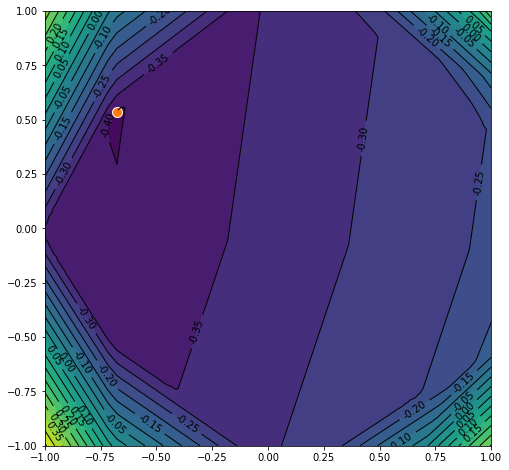

In [23]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")
plt.scatter(*xmin.data[0].tolist(), s=100, edgecolors="white")

In [24]:
minima = xmin.data
min_val = ymin.data[0].item()
minima, min_val

(tensor([[-0.6767,  0.5359]]), -0.4031238257884979)

## Using Learned function for Distance

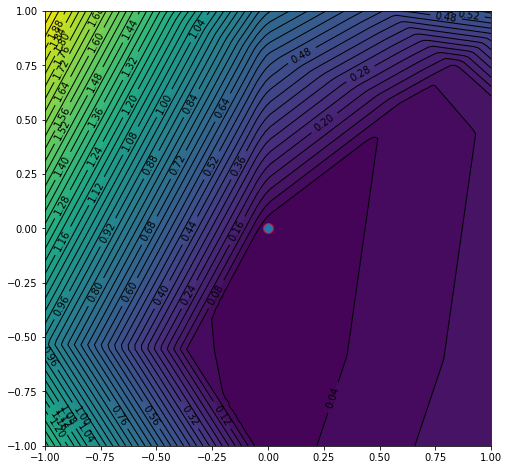

In [51]:
xx_ = xx + minima
y_ = cvxNet(xx_).data.cpu().numpy().reshape(Y.shape)- min_val
# y_ = y_**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=100, edgecolors="red")

## Contour as Distance

In [116]:
def get_contour_distance(level=1.0):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
    xx_= xx_/x_norm*level
    y_ = cvxNet(xx_+ minima) - min_val
    y_ = y_*x_norm/level
#     y_ = 1/y_*x_norm/level ### This also works but takes inverse distance

    return y_

<a list of 67 text.Text objects>

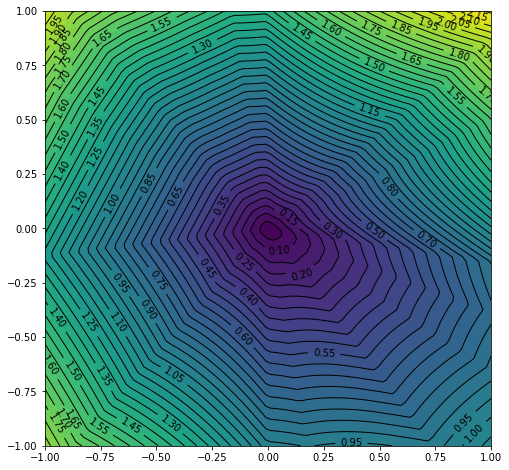

In [117]:
y_ = get_contour_distance(3.5).data.cpu().numpy().reshape(Y.shape)#**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# plt.scatter(0, 0, s=100, edgecolors="red")

In [49]:
y_.min()

0.010832296

In [60]:
'''
Observation: -> for some noisy minima found...
1) The function seems like a convex contour of different shape. (not always convex - sometimes 1-invex)
2) The magnitude of slope of the function in different direction seems different.
        (Having same slope in all direction would mean a good distance like Lp-norms)
'''

'\nObservation: -> for some noisy minima found...\n1) The function seems like a convex contour of same shape. (not always convex - sometimes 1-invex)\n2) The magnitude of slope of the function in different direction seems different.\n        (Having same slope in all direction would mean a good distance like Lp-norms)\n'

In [76]:
def get_contour_distance_lp(level=1.0, p=1):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
    xx_= xx_/x_norm*level
    y_ = torch.norm(xx_, p=p, dim=1, keepdim=True)
    y_ = y_*x_norm#/level
    return y_

<a list of 112 text.Text objects>

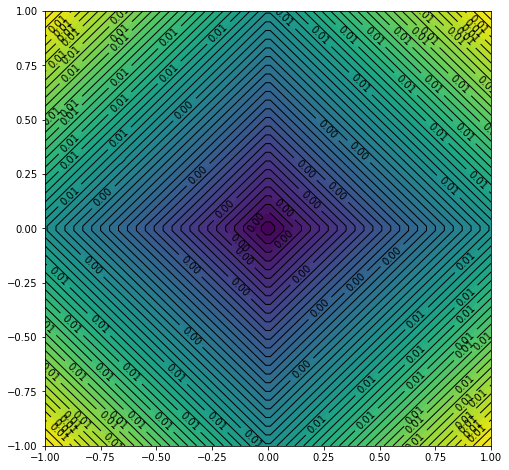

In [85]:
y_ = get_contour_distance_lp(0.005, p=1).data.cpu().numpy().reshape(Y.shape)

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# plt.scatter(0, 0, s=100, edgecolors="red")

In [78]:
def get_contour_distance_v2(level=1.0):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
#     xx_= xx_/x_norm*level
    y_ = cvxNet(xx_+ minima) - min_val
#     y_ = y_*x_norm/level

    xx_2= xx*y_/x_norm
#     y_2 = cvxNet(xx_2+ minima) - min_val

    y_2 = torch.norm(xx_2, p=2, dim=1, keepdim=True)
    
    
    return y_2

In [79]:
def get_contour_distance_v3(level=1.0):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
    xx_= xx_/x_norm*level
    y_ = cvxNet(xx+ minima) - min_val
    y_ = y_*x_norm/level
    return y_

<a list of 55 text.Text objects>

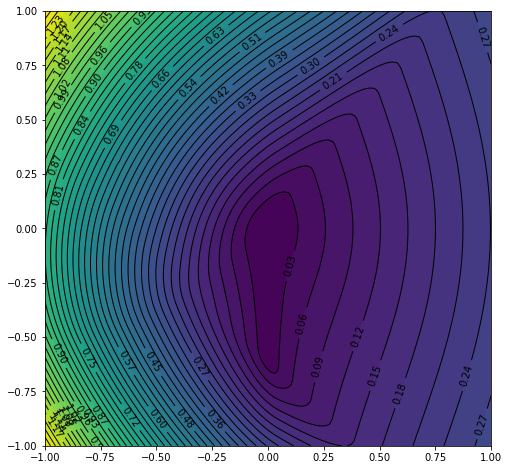

In [83]:
y_ = get_contour_distance_v3(2).data.cpu().numpy().reshape(Y.shape)**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# plt.scatter(0, 0, s=100, edgecolors="red")

In [269]:
xx[y_.argmin()]

tensor([0.0101, 0.0101])

### Extracting the Exact Contour 

In [58]:
"""
PROBLEM:
A. The contours generated by using convex function as a distance can produce non-convex contours.
B. Extracting the exact contours given a function is difficult (not made in such a way)


SOLUTION
Getting distance to a specific contour (a) in a given direction from the center. 
1. Make mimima at given (a) and optimize xx only in the magnitude. The final xx is the contour.
    a) initialize xx to unit-norm(or a) so that slight misplace in minima does not alter contour to (a)
2. distance = ||initial xx||  /  ||final xx||

BETTER -> get the exact 
"""

'\nGetting distance to a specific contour (a) in a given direction from the center. \n1. Make mimima at given (a) and optimize xx only in the magnitude. The final xx is the contour.\n'

In [60]:
xx.shape

torch.Size([10000, 2])

In [105]:
level = 0.05
xx_norm = torch.norm(xx, dim=1, keepdim=True)
xx_ = xx/xx_norm * level

In [106]:
xx_lnorm = torch.ones_like(xx_norm)*0.5
xx_lnorm = torch.autograd.Variable(xx_lnorm, requires_grad=True)
xx_lnorm

tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.5000],
        [0.5000],
        [0.5000]], requires_grad=True)

In [107]:
optim = torch.optim.Adam([xx_lnorm], lr=0.01)
STEPS = 4000

### Training Loop

In [108]:
for step in range(STEPS):
    optimizer.zero_grad() 

    yy_ = torch.abs(cvxNet(xx_*xx_lnorm + minima) - min_val - level)
    xgrad = torch.autograd.grad(outputs=yy_, inputs=xx_lnorm, grad_outputs=torch.ones_like(yy_), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xx_lnorm.grad = xgrad
    
    optim.step()
    
    if step%100 == 0:
        print(f"STEPS: {step}, norm_min: {xx_lnorm.data.min()}, norm_max: {xx_lnorm.data.max()}, min_value: {ymin.data.min()}")

STEPS: 0, norm_min: 0.5099998116493225, norm_max: 0.5099999904632568, min_value: 0.0
STEPS: 100, norm_min: 0.8548340797424316, norm_max: 1.806764006614685, min_value: 0.0
STEPS: 200, norm_min: 0.8544644117355347, norm_max: 3.314509391784668, min_value: 0.0
STEPS: 300, norm_min: 0.8546817898750305, norm_max: 4.697784423828125, min_value: 0.0
STEPS: 400, norm_min: 0.8547711372375488, norm_max: 5.964963436126709, min_value: 0.0
STEPS: 500, norm_min: 0.8546939492225647, norm_max: 7.169741630554199, min_value: 0.0
STEPS: 600, norm_min: 0.8546754121780396, norm_max: 8.326915740966797, min_value: 0.0
STEPS: 700, norm_min: 0.8544899821281433, norm_max: 9.371539115905762, min_value: 0.0
STEPS: 800, norm_min: 0.8544909358024597, norm_max: 10.279879570007324, min_value: 0.0
STEPS: 900, norm_min: 0.8544638156890869, norm_max: 11.324962615966797, min_value: 0.0
STEPS: 1000, norm_min: 0.8542718291282654, norm_max: 12.703813552856445, min_value: 0.0
STEPS: 1100, norm_min: 0.8542704582214355, norm_max

<a list of 38 text.Text objects>

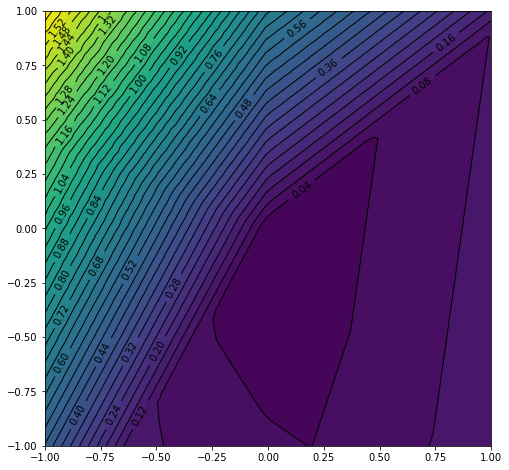

In [109]:
y_ = (xx_norm/xx_lnorm.data).cpu().reshape(X1.shape)

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

In [79]:
y_.shape

torch.Size([10000, 1])

## Convex Function for refrence

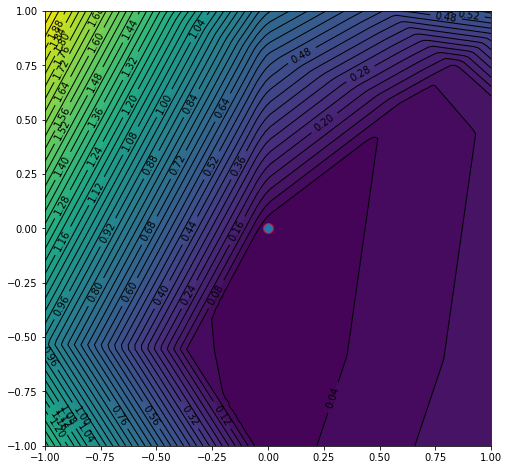

In [82]:
xx_ = xx + minima
y_ = cvxNet(xx_).data.cpu().numpy().reshape(Y.shape)- min_val
# y_ = y_**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=100, edgecolors="red")